# EDSA Apple Price Challenge

@ Melusi Zwane
@ Itumeleng Mabaso
@ Onkarabile Tshele
@ lydia lehutjo
@ Samuel Moloantoa

## Problem background
Imagine you are in the Fresh Produce Industry. How much stock do you have on hand? Not too little that you run out of stock when customers want to buy more. And not too much that food waste occurs. How do you set your prices? Yields from farms fluctuate by season. Should your prices then also fluctuate by season?

We want to construct a regression algorithm, capable of accurately predicting how much a kilogram of Golden Delicious Apples will cost, given certain parameters.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being able to accurately determine how much stock to have on hand and what price to set the Golden Delicious Apples to.

# Contents of notebook
1. Data cleaning and formatting
2. Exploratory data analysis
3. Feature engineering and selection
4. Model selection and evaluation
5. Model results
6. Conclusion

# Importing Libraries

In [1221]:
# Regression models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Visualisations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Other
import numpy as np
import pandas as pd
from scipy import stats
import math
import pickle
import warnings
warnings.filterwarnings('ignore')

# Importing Data

In [1222]:
train = pd.read_csv('https://raw.githubusercontent.com/onkarabiletshele/Regression_AM6_DSFT/main/Data/df-train_set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/onkarabiletshele/Regression_AM6_DSFT/main/Data/df-test_set.csv')
sample_submission = pd.read_csv('https://raw.githubusercontent.com/onkarabiletshele/Regression_AM6_DSFT/main/Data/sample_submission.csv')


index = test['Index']
test = test.drop('Index', axis=1)

# 1. Data cleaning and formatting

Since our focus is on Apple Golden Delicious only, we will filter out Apple Golden and drop the Commodities.

In [1223]:
train = train[train['Commodities']=='APPLE GOLDEN DELICIOUS'].drop(columns='Commodities')

In [1224]:
train.head()

,Province,Container,Size_Grade,Weight_Kg,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
1,CAPE,M4183,1L,18.3,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
7,CAPE,JG110,2M,11.0,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11
40,CAPE,M4183,1S,18.3,2020-05-04,80.0,120.0,32020.0,388,7100.4,443,4.51
69,EASTERN CAPE,IA400,1S,400.0,2020-09-28,1800.0,1800.0,1800.0,1,400.0,2,4.50


In [1225]:
# Summary statistics
train.describe()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000
mean,40.460912,174.307377,215.648053,20053.533811,174.510758,2960.176332,408.393955,6.778893
std,99.655169,373.553578,433.546159,39005.069445,308.810797,6097.416527,724.450582,2.248744
min,3.000000,2.000000,5.000000,5.000000,1.000000,3.000000,0.000000,0.250000
25%,9.000000,50.000000,60.000000,1325.000000,12.000000,219.600000,9.000000,5.460000
50%,12.000000,80.000000,108.000000,5495.000000,64.000000,853.500000,126.500000,6.670000
75%,18.300000,127.250000,160.000000,21082.500000,200.000000,3093.525000,468.000000,8.280000
max,400.000000,2300.000000,3300.000000,369464.000000,4237.000000,74000.000000,6400.000000,21.240000


In [1226]:
# Evaluate for correct data types 
train.dtypes

Province             object
Container            object
Size_Grade           object
Weight_Kg           float64
Date                 object
Low_Price           float64
High_Price          float64
Sales_Total         float64
Total_Qty_Sold        int64
Total_Kg_Sold       float64
Stock_On_Hand         int64
avg_price_per_kg    float64
dtype: object

In [1227]:
# Changing the Date to Day and Month
train['Date'] = pd.to_datetime(train['Date'])
train['Day'] = train['Date'].dt.day
train['Month'] = train['Date'].dt.month
train.drop(['Date'], inplace = True, axis = 1)

In [1228]:
train.head(5)

,Province,Container,Size_Grade,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg,Day,Month
1,CAPE,M4183,1L,18.3,150.0,170.0,51710.0,332,6075.6,822,8.51,9,9
7,CAPE,JG110,2M,11.0,50.0,50.0,16000.0,320,3520.0,0,4.55,14,4
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,55.0,55.0,990.0,18,162.0,1506,6.11,16,4
40,CAPE,M4183,1S,18.3,80.0,120.0,32020.0,388,7100.4,443,4.51,4,5
69,EASTERN CAPE,IA400,1S,400.0,1800.0,1800.0,1800.0,1,400.0,2,4.50,28,9


In [1229]:
# Changing the column names all to lowercase 
train.columns = ['province', 'container', 'size_grade', 'weight_kg', 'low_price', 
                 'high_price', 'sales_total', 'total_qty_sold','total_kg_sold', 
                 'stock_on_hand', 'avg_price_per_kg', 'day', 'month']

In [1230]:
train

,province,container,size_grade,weight_kg,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg,day,month
1,CAPE,M4183,1L,18.3,150.0,170.0,51710.0,332,6075.6,822,8.51,9,9
7,CAPE,JG110,2M,11.0,50.0,50.0,16000.0,320,3520.0,0,4.55,14,4
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,55.0,55.0,990.0,18,162.0,1506,6.11,16,4
40,CAPE,M4183,1S,18.3,80.0,120.0,32020.0,388,7100.4,443,4.51,4,5
69,EASTERN CAPE,IA400,1S,400.0,1800.0,1800.0,1800.0,1,400.0,2,4.50,28,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64276,NATAL,EC120,1S,12.0,96.0,96.0,1920.0,20,240.0,53,8.00,4,3
64291,ORANGE FREE STATE,M4183,1X,18.3,130.0,130.0,7280.0,56,1024.8,74,7.10,22,2
64297,CAPE,JE090,2M,9.0,50.0,60.0,4540.0,89,801.0,793,5.67,22,4
64304,CAPE,JG110,2M,11.0,30.0,40.0,2140.0,70,770.0,0,2.78,4,3


### Checking the distribution 

<AxesSubplot:xlabel='avg_price_per_kg', ylabel='Density'>

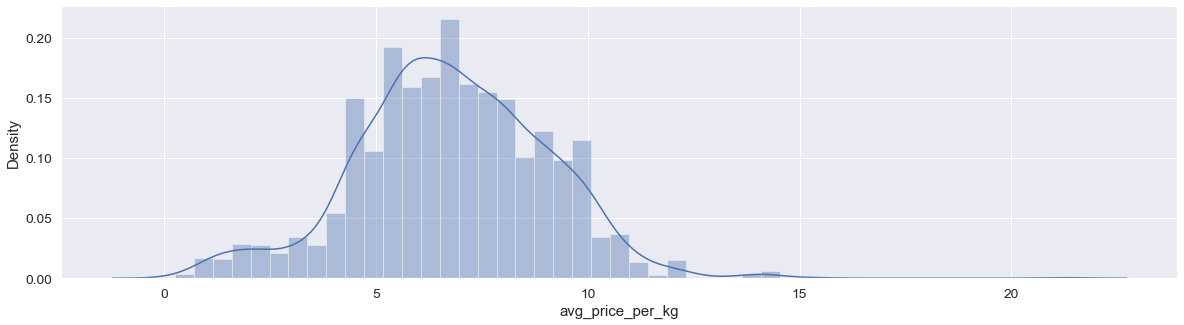

In [1231]:
fig, ax = plt.subplots(figsize=(20,5))
sns.distplot(train['avg_price_per_kg'], kde=True)

# 2. Exploratory data analysis

### 2.1 Identifying missing values

In [1232]:
# missing values
def missing_values_table(df):
        mis_val = df.isnull().sum()
        
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [1233]:
missing_values_table(train)

Your selected dataframe has 13 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## 2.2 Exploring the correlation of the target variable and predictor variables

In [1234]:
# Checking for correlation between target  variable and numerical variables
train.corr()

,weight_kg,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg,day,month
weight_kg,1.000000,0.863182,0.905852,0.180518,-0.133317,0.294117,-0.144105,-0.337886,0.016251,0.047613
low_price,0.863182,1.000000,0.938140,0.183230,-0.122823,0.269744,-0.127677,-0.141740,-0.015764,0.039084
high_price,0.905852,0.938140,1.000000,0.265672,-0.096456,0.372282,-0.094174,-0.164496,0.002058,0.047717
sales_total,0.180518,0.183230,0.265672,1.000000,0.771865,0.962338,0.284693,0.108473,-0.011699,-0.055853
total_qty_sold,-0.133317,-0.122823,-0.096456,0.771865,1.000000,0.651440,0.390168,0.087536,-0.020402,-0.058639
total_kg_sold,0.294117,0.269744,0.372282,0.962338,0.651440,1.000000,0.229062,-0.001007,0.003238,-0.023098
stock_on_hand,-0.144105,-0.127677,-0.094174,0.284693,0.390168,0.229062,1.000000,0.105028,0.081923,-0.011749
avg_price_per_kg,-0.337886,-0.141740,-0.164496,0.108473,0.087536,-0.001007,0.105028,1.000000,-0.071334,0.005205
day,0.016251,-0.015764,0.002058,-0.011699,-0.020402,0.003238,0.081923,-0.071334,1.000000,0.010012
month,0.047613,0.039084,0.047717,-0.055853,-0.058639,-0.023098,-0.011749,0.005205,0.010012,1.000000


To observe the correlation clearly, we will use a heatmap to visualse the correlation

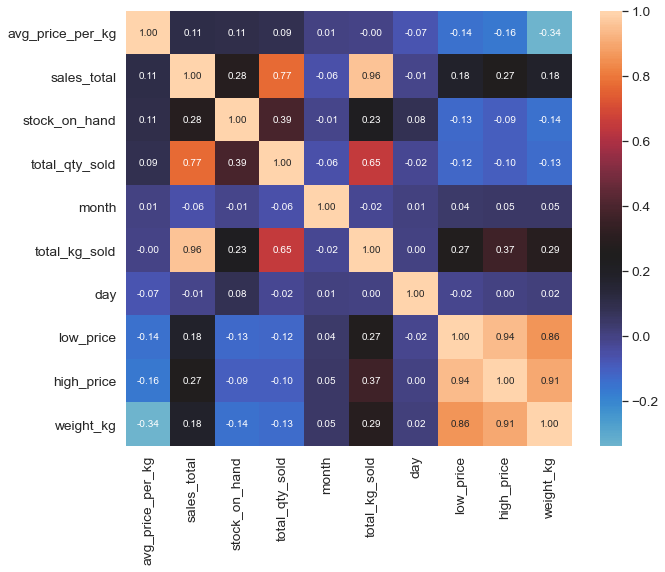

In [1235]:
plt.figure(figsize=(10,8))

#avg_price_per_kg correlation matrix
cols = train.corr().nlargest(10, 'avg_price_per_kg')['avg_price_per_kg'].index
corr_mat = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)

#Plot corr matrix
sns.heatmap(corr_mat, annot=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, center=0.25)
plt.show()

In [1236]:
# Taking a look at how our numerical features correlate with our target 
corrs_numerical = pd.DataFrame(train.corr()['avg_price_per_kg'])#.rename(columns = {'avg_price_per_kg':'Correlation'})
#corrs_numerical.sort_values(by='Correlation',ascending=False, inplace=True)
corrs_numerical.head(10)

,avg_price_per_kg
weight_kg,-0.337886
low_price,-0.141740
high_price,-0.164496
sales_total,0.108473
total_qty_sold,0.087536
total_kg_sold,-0.001007
stock_on_hand,0.105028
avg_price_per_kg,1.000000
day,-0.071334
month,0.005205


Judging from the above results, the strongest correlation are Weight, Low Price and High Price (even though  it is a negative relationship)

In [1237]:
train

,province,container,size_grade,weight_kg,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg,day,month
1,CAPE,M4183,1L,18.3,150.0,170.0,51710.0,332,6075.6,822,8.51,9,9
7,CAPE,JG110,2M,11.0,50.0,50.0,16000.0,320,3520.0,0,4.55,14,4
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,55.0,55.0,990.0,18,162.0,1506,6.11,16,4
40,CAPE,M4183,1S,18.3,80.0,120.0,32020.0,388,7100.4,443,4.51,4,5
69,EASTERN CAPE,IA400,1S,400.0,1800.0,1800.0,1800.0,1,400.0,2,4.50,28,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64276,NATAL,EC120,1S,12.0,96.0,96.0,1920.0,20,240.0,53,8.00,4,3
64291,ORANGE FREE STATE,M4183,1X,18.3,130.0,130.0,7280.0,56,1024.8,74,7.10,22,2
64297,CAPE,JE090,2M,9.0,50.0,60.0,4540.0,89,801.0,793,5.67,22,4
64304,CAPE,JG110,2M,11.0,30.0,40.0,2140.0,70,770.0,0,2.78,4,3


### Visualising the corelation between the target varible and predictor variables 

In [1238]:
# Encoding categorical features with dummy variables to observe how they correlate with target 
dummy_df = pd.get_dummies(train, drop_first=True)

In [1239]:
dummy_df.head(5)

,weight_kg,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg,day,month,...,container_M9125,size_grade_1M,size_grade_1S,size_grade_1U,size_grade_1X,size_grade_2L,size_grade_2M,size_grade_2S,size_grade_2U,size_grade_2X
1,18.3,150.0,170.0,51710.0,332,6075.6,822,8.51,9,9,...,0,0,0,0,0,0,0,0,0,0
7,11.0,50.0,50.0,16000.0,320,3520.0,0,4.55,14,4,...,0,0,0,0,0,0,1,0,0,0
24,9.0,55.0,55.0,990.0,18,162.0,1506,6.11,16,4,...,0,0,0,0,0,0,0,1,0,0
40,18.3,80.0,120.0,32020.0,388,7100.4,443,4.51,4,5,...,0,0,1,0,0,0,0,0,0,0
69,400.0,1800.0,1800.0,1800.0,1,400.0,2,4.50,28,9,...,0,0,1,0,0,0,0,0,0,0


In [1240]:
column_titles = [col for col in dummy_df.columns if col!= 'avg_price_per_kg'] + ['avg_price_per_kg']
dummy_df=dummy_df.reindex(columns=column_titles)

We didnt inclulde the Commodities columns since we are only focusing on one commodity 

In [1241]:
# Taking a look at how our categorical features correlate with our target 
corrs_categorical = dummy_df.corr()['avg_price_per_kg'].sort_values(ascending=False)
corrs_categorical.head(10)

avg_price_per_kg                 1.000000
container_M4183                  0.403229
province_W.CAPE-BERGRIVER ETC    0.262051
size_grade_1X                    0.251451
container_EC120                  0.188162
size_grade_1M                    0.175779
container_EF120                  0.114297
sales_total                      0.108473
stock_on_hand                    0.105028
total_qty_sold                   0.087536
Name: avg_price_per_kg, dtype: float64

Judging from the above results, the Container, Size Grade has an impact on the target variable.

In [1242]:
dummy_df.columns

Index(['weight_kg', 'low_price', 'high_price', 'sales_total', 'total_qty_sold',
       'total_kg_sold', 'stock_on_hand', 'day', 'month',
       'province_EASTERN CAPE', 'province_NATAL', 'province_ORANGE FREE STATE',
       'province_TRANSVAAL', 'province_W.CAPE-BERGRIVER ETC',
       'province_WEST COAST', 'container_DT063', 'container_EC120',
       'container_EF120', 'container_EG140', 'container_IA400',
       'container_JE090', 'container_JG110', 'container_M4183',
       'container_M6125', 'container_M9125', 'size_grade_1M', 'size_grade_1S',
       'size_grade_1U', 'size_grade_1X', 'size_grade_2L', 'size_grade_2M',
       'size_grade_2S', 'size_grade_2U', 'size_grade_2X', 'avg_price_per_kg'],
      dtype='object')

In [1243]:
from scipy.stats import pearsonr

# Build a dictionary of correlation coefficients and p-values
dict_cp = {}

column_titles = [col for col in corrs_categorical.index if col!= 'avg_price_per_kg']
for col in column_titles:
    p_val = round(pearsonr(dummy_df[col], dummy_df['avg_price_per_kg'])[1],6)
    dict_cp[col] = {'Correlation_Coefficient':corrs_categorical[col],
                    'P_Value':p_val}
    
df_cp = pd.DataFrame(dict_cp).T
df_cp_sorted = df_cp.sort_values('P_Value')
df_cp_sorted[df_cp_sorted['P_Value'] < 1]

,Correlation_Coefficient,P_Value
container_M4183,0.403229,0.000000
size_grade_2S,-0.352996,0.000000
weight_kg,-0.337886,0.000000
container_JE090,-0.322235,0.000000
province_EASTERN CAPE,-0.178531,0.000000
high_price,-0.164496,0.000000
size_grade_2M,-0.153372,0.000000
low_price,-0.141740,0.000000
container_JG110,-0.140148,0.000000
container_IA400,-0.355565,0.000000


## 2.2 Identifying outliers 

<AxesSubplot:xlabel='month'>

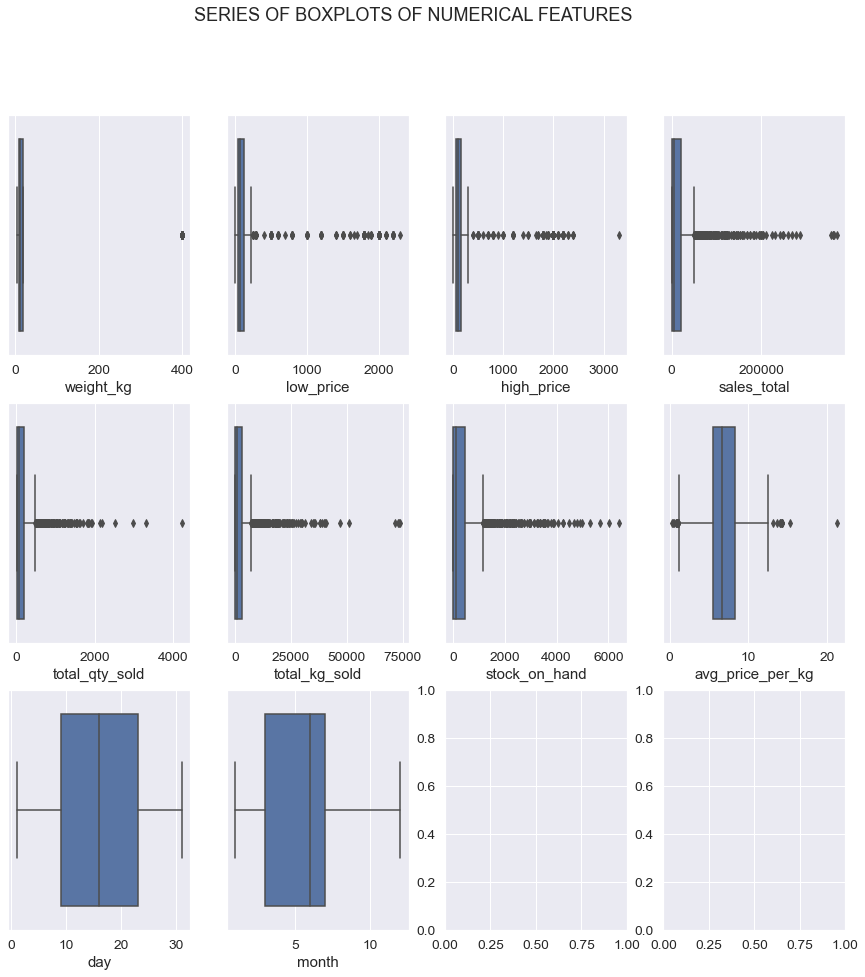

In [1244]:
# Visualizing the outliers using boxplot graph 
fig, axes = plt.subplots(3, 4, figsize=(15, 15))

fig.suptitle('SERIES OF BOXPLOTS OF NUMERICAL FEATURES')

sns.boxplot(ax=axes[0, 0], data=train, x='weight_kg')
sns.boxplot(ax=axes[0, 1], data=train, x='low_price')
sns.boxplot(ax=axes[0, 2], data=train, x='high_price')
sns.boxplot(ax=axes[0, 3], data=train, x='sales_total')
sns.boxplot(ax=axes[1, 0], data=train, x='total_qty_sold')
sns.boxplot(ax=axes[1, 1], data=train, x='total_kg_sold')
sns.boxplot(ax=axes[1, 2], data=train, x='stock_on_hand')
sns.boxplot(ax=axes[1, 3], data=train, x='avg_price_per_kg')
sns.boxplot(ax=axes[2, 0], data=train, x='day')
sns.boxplot(ax=axes[2, 1], data=train, x='month')

In [1245]:
# info about kurtois

In [1246]:
# Checking the kurtosis of our data
train.kurtosis()

weight_kg            9.109698
low_price           17.073369
high_price          13.630768
sales_total         24.200524
total_qty_sold      32.338123
total_kg_sold       45.153801
stock_on_hand       14.671224
avg_price_per_kg     1.042921
day                 -1.122178
month               -0.620111
dtype: float64

In [1247]:
# info about skewness

In [1248]:
# Checking the skewness of our data 
train.skew()

weight_kg           3.328254
low_price           4.222672
high_price          3.828819
sales_total         4.250317
total_qty_sold      4.445169
total_kg_sold       5.529586
stock_on_hand       3.391815
avg_price_per_kg    0.082452
day                -0.021883
month               0.078651
dtype: float64

## 3. Feature engineering and selection

Based on our findings regarding the correlations, we will select the features that had the strongest relationship with target

train = pd.concat([train, dummy_df], axis=1)
train.head()

train.drop(columns=["province", "size_grade", "container"], axis=1, inplace=True)

train.columns

train = pd.concat([train, dummy_df], axis=1)
train.head()

train.drop(columns=["province", "size_grade", "container"], axis=1, inplace=True)

train.columns

## 4. Model selection and evaluation 

In [1249]:
# Function to fit data, make predictions, and evaluate model
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_pred,y_test))

def r_squared(y_test, y_pred):
    return r2_score(y_test, y_pred)
    
# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model,X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_rmse = rmse(y_train, train_pred)
    test_rmse = rmse(y_test, test_pred)
    
    train_r2 = r_squared(y_train, train_pred)
    test_r2 = r_squared(y_test, test_pred)
    
    df = {'Train RMSE': train_rmse,'Train R^2':train_r2,'Test RMSE': test_rmse,'Test R^2':test_r2}
    
    return df

### 4.1 Basic linear regression model

In [955]:
model = LinearRegression()
y = train['avg_price_per_kg']
y.shape

(1952,)

In [956]:
X = train.drop(columns='avg_price_per_kg')
fit_and_evaluate(model,X,y)

{'Train RMSE': 1.6288796888512445,
 'Train R^2': 0.485282373413746,
 'Test RMSE': 1.593027712885468,
 'Test R^2': 0.4530868569571118}

In [957]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=4)
model.fit(X_train, y_train)

LinearRegression()

### 4.2 Random Forest Regression

In [908]:
model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=90, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [909]:
fit_and_evaluate(model, X_train, y_train)

{'Train RMSE': 0.4675277021906842,
 'Train R^2': 0.9544577255564736,
 'Test RMSE': 1.0229357211136278,
 'Test R^2': 0.8308381517169996}

In [910]:
train.shape

(1952, 13)

In [911]:
X = train.drop(columns='avg_price_per_kg')
y=train['avg_price_per_kg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=4)
fit_and_evaluate(model,X,y)

{'Train RMSE': 0.49597354756863893,
 'Train R^2': 0.9522791628568386,
 'Test RMSE': 0.6719690639836463,
 'Test R^2': 0.9026871353724487}

### 4.3 Ridge Regression 

In [585]:
train.columns

Index(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Low_Price',
       'High_Price', 'Sales_Total', 'Total_Qty_Sold', 'Total_Kg_Sold',
       'Stock_On_Hand', 'avg_price_per_kg', 'Day', 'Month'],
      dtype='object')

In [586]:
# Separate the features from the response
X = train[['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Low_Price',
       'High_Price', 'Sales_Total', 'Total_Qty_Sold', 'Total_Kg_Sold',
       'Stock_On_Hand', 'avg_price_per_kg', 'Day', 'Month']].drop('avg_price_per_kg', axis=1)
y = train['avg_price_per_kg']

In [587]:
# Import the scaling module
from sklearn.preprocessing import StandardScaler

In [588]:
# Create standardization object
scaler = StandardScaler()

In [589]:
# Save standardized features into new variable
X_scaled = scaler.fit_transform(X)

In [590]:
# Convert the scaled predictor values into a dataframe
X_standardise = pd.DataFrame(X_scaled,columns=X.columns)
X_standardise.head()

,Province,Container,Size_Grade,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Day,Month
0,-0.772788,1.062453,-1.329835,-0.222433,-0.065087,-0.105317,0.811807,0.510117,0.511073,0.571070,-0.788911,1.262165
1,-0.772788,0.645671,1.033240,-0.295704,-0.332855,-0.382175,-0.103950,0.471248,0.091837,-0.563874,-0.214430,-0.598952
2,1.400192,0.228889,1.427086,-0.315779,-0.319467,-0.370639,-0.488870,-0.506948,-0.459029,1.515476,0.015363,-0.598952
3,-0.772788,1.062453,-0.542143,-0.222433,-0.252525,-0.220674,0.306871,0.691504,0.679187,0.047781,-1.363392,-0.226728
4,-0.338192,-0.187894,-0.542143,3.608756,4.353082,3.655338,-0.468098,-0.562012,-0.419986,-0.561112,1.394117,1.262165


In [591]:
# Import train/test splitting function from sklearn
from sklearn.model_selection import train_test_split

In [592]:
# Split the data into train and test, being sure to use the standardised predictors
X_train, X_test, y_train, y_test = train_test_split(X_standardise, 
                                                    y, 
                                                    test_size=0.2, 
                                                    shuffle=False)

In [593]:
# Import the ridge regression module from sklearn
from sklearn.linear_model import Ridge

In [594]:
# Create ridge model
ridge = Ridge()

In [595]:
# Train the model
ridge.fit(X_train, y_train)

Ridge()

In [596]:
# Extract the model intercept value
b0 = float(ridge.intercept_)

In [597]:
# Extract the model coefficient value
coeff = pd.DataFrame(ridge.coef_, X.columns, columns=['Coefficient'])

In [598]:
print("Intercept:", float(b0))

Intercept: 6.810319899755304


In [599]:
# Check out the coefficients
coeff

,Coefficient
Province,0.207050
Container,0.163630
Size_Grade,-0.769572
Weight_Kg,-1.863698
Low_Price,0.375263
High_Price,0.856007
Sales_Total,2.954270
Total_Qty_Sold,-0.715073
Total_Kg_Sold,-2.336809
Stock_On_Hand,0.040250


In [600]:
# Fit a basic linear model
from sklearn.linear_model import LinearRegression

# Create model object
model = LinearRegression()

# Train model
model.fit(X_train, y_train)

LinearRegression()

In [601]:
# Import metrics module
from sklearn import metrics

In [602]:
# Check training accuracy
train_model = model.predict(X_train)
train_ridge = ridge.predict(X_train)

In [603]:
fit_and_evaluate(model,X,y)

{'Train RMSE': 1.6288796888512445,
 'Train R^2': 0.485282373413746,
 'Test RMSE': 1.593027712885468,
 'Test R^2': 0.4530868569571118}

### 4.4 Lasso Regression

In [ ]:
# Separate the features from the response
X = train[['Weight_Kg','Low_Price','High_Price','Sales_Total','Total_Qty_Sold','Total_Kg_Sold','Sales_Total','avg_price_per_kg']].drop('avg_price_per_kg', axis=1)
y = train['avg_price_per_kg']

In [ ]:
# Import the scaling module
from sklearn.preprocessing import StandardScaler

In [ ]:
# Create standardization object
scaler = StandardScaler()

In [ ]:
# Save standardized features into new variable
X_scaled = scaler.fit_transform(X)

In [ ]:
# Import train/test split module
from sklearn.model_selection import train_test_split

In [ ]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                    y, 
                                                    test_size=0.20,
                                                    random_state=1,
                                                    shuffle=False)

In [ ]:
# Import LASSO module
from sklearn.linear_model import Lasso

In [ ]:
# Create LASSO model object, setting alpha to 0.01
lasso = Lasso(alpha=0.01)

In [ ]:
# Train the LASSO model
lasso.fit(X_train, y_train)

In [ ]:
# Extract intercept from model
intercept = float(lasso.intercept_)

In [ ]:
# Extract coefficient from model
coeff = pd.DataFrame(lasso.coef_, X.columns, columns=['Coefficient'])

In [ ]:
# Extract intercept
print("Intercept:", float(intercept))

In [ ]:
coeff

In [ ]:
# convert the scaled predictor values into a dataframe
X_standardise = pd.DataFrame(X_scaled,columns=X.columns)
X_standardise.head()

In [ ]:
plt.hist(X_standardise['High_Price'])
plt.show()

In [181]:
X_standardise.describe().loc['std']

Weight_Kg         1.000256
Low_Price         1.000256
High_Price        1.000256
Sales_Total       1.000256
Total_Qty_Sold    1.000256
Total_Kg_Sold     1.000256
Sales_Total       1.000256
Name: std, dtype: float64

In [182]:
# Fit a basic linear model
from sklearn.linear_model import LinearRegression, Ridge

X_subset = train.drop(['Province', 'Container', 'Size_Grade', 'Date', 'Commodities'], axis=1)

X_subset_scaled = scaler.fit_transform(X_subset)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_subset, 
                                                        y, 
                                                        test_size=0.20, 
                                                        random_state=1,
                                                        shuffle=False)

# Least squares using non-zero variables from LASSO
model_subset = LinearRegression()

# Least squares using all predictors
model_all = LinearRegression()

# Ridge using all predictors
ridge = Ridge()


In [183]:
fit_and_evaluate(model_subset,X_train2, y_train2)

{'Train RMSE': 6.464646907830799e-14,
 'Train R^2': 1.0,
 'Test RMSE': 6.454609359088699e-14,
 'Test R^2': 1.0}

In [184]:
fit_and_evaluate(model_all,X_train, y_train)

{'Train RMSE': 1.7729855990313965,
 'Train R^2': 0.3701881712235534,
 'Test RMSE': 1.7308629410476393,
 'Test R^2': 0.38754515877113527}

In [185]:
fit_and_evaluate(ridge,X_train, y_train)

{'Train RMSE': 1.773115580987616,
 'Train R^2': 0.37009582171498245,
 'Test RMSE': 1.732187486595205,
 'Test R^2': 0.38660743607902837}

### 4.5 Gradient Boosting Regression

In [ ]:
# Gradient Boosting Regressor
model = GradientBoostingRegressor(max_depth=4, n_estimators=200, random_state=2)

In [ ]:
fit_and_evaluate(model,X,y)

In [1061]:
train.columns

Index(['weight_kg', 'low_price', 'high_price', 'sales_total', 'total_qty_sold',
       'total_kg_sold', 'stock_on_hand', 'avg_price_per_kg', 'day', 'month',
       'weight_kg', 'low_price', 'high_price', 'sales_total', 'total_qty_sold',
       'total_kg_sold', 'stock_on_hand', 'avg_price_per_kg', 'day', 'month',
       'province_CAPE', 'province_EASTERN CAPE', 'province_NATAL',
       'province_ORANGE FREE STATE', 'province_TRANSVAAL',
       'province_W.CAPE-BERGRIVER ETC', 'province_WEST COAST',
       'container_AC030', 'container_DT063', 'container_EC120',
       'container_EF120', 'container_EG140', 'container_IA400',
       'container_JE090', 'container_JG110', 'container_M4183',
       'container_M6125', 'container_M9125', 'size_grade_1L', 'size_grade_1M',
       'size_grade_1S', 'size_grade_1U', 'size_grade_1X', 'size_grade_2L',
       'size_grade_2M', 'size_grade_2S', 'size_grade_2U', 'size_grade_2X'],
      dtype='object')

## 4.6 XGBoost

In [1338]:
dummy_df.columns

Index(['weight_kg', 'low_price', 'high_price', 'sales_total', 'total_qty_sold',
       'total_kg_sold', 'stock_on_hand', 'day', 'month',
       'province_EASTERN CAPE', 'province_NATAL', 'province_ORANGE FREE STATE',
       'province_TRANSVAAL', 'province_W.CAPE-BERGRIVER ETC',
       'province_WEST COAST', 'container_DT063', 'container_EC120',
       'container_EF120', 'container_EG140', 'container_IA400',
       'container_JE090', 'container_JG110', 'container_M4183',
       'container_M6125', 'container_M9125', 'size_grade_1M', 'size_grade_1S',
       'size_grade_1U', 'size_grade_1X', 'size_grade_2L', 'size_grade_2M',
       'size_grade_2S', 'size_grade_2U', 'size_grade_2X', 'avg_price_per_kg'],
      dtype='object')

In [1364]:
model = XGBRegressor()

X_train = dummy_df.drop(columns='avg_price_per_kg')
y_train = dummy_df['avg_price_per_kg']
X_train.shape, y_train.shape, X_test.shape

((1952, 34), (1952,), (391, 12))

In [1365]:
X_test.head()

,province,container,size_grade,weight_kg,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,day,month
25825,2,7,7,11.0,10.0,10.0,30.0,3,33.0,0,13,5
29168,0,8,2,18.3,80.0,160.0,60350.0,531,9717.3,3677,7,9
54891,0,6,7,9.0,50.0,50.0,100.0,2,18.0,76,12,8
51253,0,6,6,9.0,50.0,50.0,450.0,9,81.0,9,9,9
58909,0,6,6,9.0,50.0,70.0,1520.0,27,243.0,405,3,9


In [1366]:
X_train.columns

Index(['weight_kg', 'low_price', 'high_price', 'sales_total', 'total_qty_sold',
       'total_kg_sold', 'stock_on_hand', 'day', 'month',
       'province_EASTERN CAPE', 'province_NATAL', 'province_ORANGE FREE STATE',
       'province_TRANSVAAL', 'province_W.CAPE-BERGRIVER ETC',
       'province_WEST COAST', 'container_DT063', 'container_EC120',
       'container_EF120', 'container_EG140', 'container_IA400',
       'container_JE090', 'container_JG110', 'container_M4183',
       'container_M6125', 'container_M9125', 'size_grade_1M', 'size_grade_1S',
       'size_grade_1U', 'size_grade_1X', 'size_grade_2L', 'size_grade_2M',
       'size_grade_2S', 'size_grade_2U', 'size_grade_2X'],
      dtype='object')

In [1376]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=2,
             min_child_weight=13, missing=nan, monotone_constraints='()',
             n_estimators=6000, n_jobs=4, num_parallel_tree=1, random_state=16,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [1377]:
fit_and_evaluate(model,X_train, y_train)

{'Train RMSE': 0.03910182792845369,
 'Train R^2': 0.9997033904393697,
 'Test RMSE': 0.3204976849342551,
 'Test R^2': 0.9778628610135205}

In [1345]:
X_train.columns

Index(['weight_kg', 'low_price', 'high_price', 'total_qty_sold',
       'total_kg_sold', 'province_EASTERN CAPE', 'province_NATAL',
       'province_W.CAPE-BERGRIVER ETC', 'container_EC120', 'container_EF120',
       'container_IA400', 'container_JE090', 'container_JG110',
       'size_grade_1M', 'size_grade_1X', 'size_grade_2M', 'size_grade_2S'],
      dtype='object')

In [1369]:
model = XGBRegressor(max_depth=2,min_child_weight=13,subsample=1,colsample_bytree=1,
            objective='reg:squarederror',n_estimators=6000, learning_rate=0.3, random_state= 16)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=2,
             min_child_weight=13, missing=nan, monotone_constraints='()',
             n_estimators=6000, n_jobs=4, num_parallel_tree=1, random_state=16,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [1370]:
fit_and_evaluate(model,X_train, y_train)

{'Train RMSE': 0.03910182792845369,
 'Train R^2': 0.9997033904393697,
 'Test RMSE': 0.3204976849342551,
 'Test R^2': 0.9778628610135205}

## 5. Model results

In [1261]:
test.shape, train.shape

((685, 12), (1952, 13))

In [1262]:
# need to change date datatype
test['Date'] = pd.to_datetime(test['Date'])
test['Day'] = test['Date'].dt.day
test['Month'] = test['Date'].dt.month
test.drop(['Date'], inplace = True, axis = 1)

In [1263]:
test=test[test['Commodities']=='APPLE GOLDEN DELICIOUS'].drop(columns='Commodities')

In [1264]:
test.columns

Index(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Low_Price',
       'High_Price', 'Sales_Total', 'Total_Qty_Sold', 'Total_Kg_Sold',
       'Stock_On_Hand', 'Day', 'Month'],
      dtype='object')

In [1265]:
test.columns = ['province', 'container', 'size_grade', 'weight_kg', 'low_price', 
                 'high_price', 'sales_total', 'total_qty_sold','total_kg_sold', 
                 'stock_on_hand', 'day', 'month']

In [1266]:
# Encoding categorical features with dummy variables to observe how they correlate with target 
dummy_test = pd.get_dummies(test, drop_first=True)

In [1274]:
dummy_test.columns

Index(['weight_kg', 'low_price', 'high_price', 'sales_total', 'total_qty_sold',
       'total_kg_sold', 'stock_on_hand', 'day', 'month',
       'province_EASTERN CAPE', 'province_NATAL', 'province_ORANGE FREE STATE',
       'province_TRANSVAAL', 'province_W.CAPE-BERGRIVER ETC',
       'province_WEST COAST', 'container_DT063', 'container_EC120',
       'container_EF120', 'container_EG140', 'container_IA400',
       'container_JE090', 'container_JG110', 'container_M4183',
       'container_M6125', 'container_M9125', 'size_grade_1M', 'size_grade_1S',
       'size_grade_1U', 'size_grade_1X', 'size_grade_2L', 'size_grade_2M',
       'size_grade_2S', 'size_grade_2U', 'size_grade_2X'],
      dtype='object')

In [1285]:
dummy_test.columns

Index(['weight_kg', 'low_price', 'high_price', 'sales_total', 'total_qty_sold',
       'total_kg_sold', 'stock_on_hand', 'day', 'month',
       'province_EASTERN CAPE', 'province_NATAL', 'province_ORANGE FREE STATE',
       'province_TRANSVAAL', 'province_W.CAPE-BERGRIVER ETC',
       'province_WEST COAST', 'container_DT063', 'container_EC120',
       'container_EF120', 'container_EG140', 'container_IA400',
       'container_JE090', 'container_JG110', 'container_M4183',
       'container_M6125', 'container_M9125', 'size_grade_1M', 'size_grade_1S',
       'size_grade_1U', 'size_grade_1X', 'size_grade_2L', 'size_grade_2M',
       'size_grade_2S', 'size_grade_2U', 'size_grade_2X'],
      dtype='object')

In [1294]:
test =dummy_test

In [1295]:
dummy_test.head()

,weight_kg,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,day,month,province_EASTERN CAPE,...,container_M9125,size_grade_1M,size_grade_1S,size_grade_1U,size_grade_1X,size_grade_2L,size_grade_2M,size_grade_2S,size_grade_2U,size_grade_2X
0,12.0,128.0,136.0,5008.0,38,456.0,0,9,7,0,...,0,1,0,0,0,0,0,0,0,0
1,18.3,220.0,220.0,1760.0,8,146.4,2,20,1,0,...,0,0,0,0,1,0,0,0,0,0
2,12.0,120.0,120.0,720.0,6,72.0,45,19,8,0,...,0,0,1,0,0,0,0,0,0,0
3,18.3,160.0,160.0,160.0,1,18.3,8,6,5,0,...,0,1,0,0,0,0,0,0,0,0
4,18.3,140.0,160.0,14140.0,100,1830.0,19,4,5,0,...,0,0,0,0,0,0,0,0,0,0


In [1378]:
# save the model
import pickle

model_load_path= "model.pkl"
with open(model_load_path, 'wb') as file:
    pickle.dump(model, file)

with open(model_load_path,'rb') as file:
    mod = pickle.load(file)

In [1379]:
preds = mod.predict(test)

In [1380]:
submission = pd.DataFrame(
    {'Index': index,
     'avg_price_per_kg': preds
    })

In [1381]:
submission.head(10)

,Index,avg_price_per_kg
0,1,11.124663
1,2,12.133077
2,3,9.814767
3,4,9.038456
4,5,7.843409
5,6,4.659199
6,7,3.649379
7,8,7.675863
8,9,8.593639
9,10,9.350963


In [1382]:
submission.to_csv("submission.csv", index=False)

## 6. Conclusion